
# Popular Data Science Questions 


You're working for a company that creates data science content, be it books, online articles, videos or interactive text-based platforms like Dataquest.

You're tasked with figuring out what is best content to write about. Because you took this course, you know that given the lack of instructions there's some leeway in what "best" means here.

Since you're passionate about helping people learn, you decide to scower the internet in search for the answer to the question "What is it that people want to learn about in data science?" (as opposed to determining the most profitable content, for instance).

The fact that Data Science Stack Exchange (DSSE) is a data science dedicated site (contrarily to the others), coupled with it having a lot of an unanswered questions, makes it an ideal candidate for this investigation. DSSE will be the focus of this guided project.

## Getting the Data

Stack Exchange provides a public database for each of its websites including [for DSSE](https://data.stackexchange.com/datascience/query/edit/1200610).

The posts table has a lot of columns. We'll be focusing our attention on those that seem relevant towards our goal:

* `Id`: An identification number for the post.
* `PostTypeId`: An identification number for the type of post.
* `CreationDate`: The date and time of creation of the post.
* `Score`: The post's score.
* `ViewCount`: How many times the post was viewed.
* `Tags`: What tags were used.
* `AnswerCount`: How many answers the question got (only applicable to question posts).
* `FavoriteCount`: How many times the question was favored (only applicable to question posts).

Interested in only recent posts so limiting anlaysis to posts of 2019. 

## Getting the Data

Ran a query against the SEDE DSSE database that extracts the columns 
listed above for all the questions in 2019 & downloaded as csv file.


To get the relevant data we run the following query.

`SELECT Id, CreationDate,
       Score, ViewCount, Tags,
       AnswerCount, FavoriteCount
  FROM posts
 WHERE PostTypeId = 1 AND YEAR(CreationDate) = 2019;`



## Exploring the Data

In [1]:
# Import everything need to use

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

In [2]:
questions = pd.read_csv('dataset/2019_questions.csv', parse_dates=['CreationDate'])

In [3]:
questions.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8640 entries, 0 to 8639
Data columns (total 7 columns):
Id               8640 non-null int64
CreationDate     8640 non-null datetime64[ns]
Score            8640 non-null int64
ViewCount        8640 non-null int64
Tags             8640 non-null object
AnswerCount      8640 non-null int64
FavoriteCount    1451 non-null float64
dtypes: datetime64[ns](1), float64(1), int64(4), object(1)
memory usage: 472.6+ KB


In [4]:
print(questions.shape)

questions.isnull().sum()

(8640, 7)


Id                  0
CreationDate        0
Score               0
ViewCount           0
Tags                0
AnswerCount         0
FavoriteCount    7189
dtype: int64

`FavoriteCount` has missing values. A missing value on this column probably means that the question was is not present in any users' favorite list, so we can replace the missing values with zero.

The types seem adequate for every column, however, after we fill in the missing values on FavoriteCount, there is no reason to store the values as floats.

Since the object dtype is a catch-all type, let's see what types the objects in `questions["Tags"]` are.

In [5]:
questions["Tags"].apply(lambda value: type(value)).unique()

array([<class 'str'>], dtype=object)

We see that every value in this column is a string. On Stack Exchange, each question can only have a maximum of five tags, so one way to deal with this column is to create five columns in questions called Tag1, Tag2, Tag3, Tag4, and Tag5 and populate the columns with the tags in each row.
However, since doesn't help is relating tags from one question to another, we'll just keep them as a list.

## Cleaning the Data

Stack Exchange provide clean data so not much cleaning required.

Begin by fixing `FavoriteCount`.

In [6]:
# Filling the missing values with 0
questions.fillna(value={"FavoriteCount": 0}, inplace=True)

# Changing the types of the column
questions['FavoriteCount']= questions['FavoriteCount'].astype(int)

questions.dtypes

Id                        int64
CreationDate     datetime64[ns]
Score                     int64
ViewCount                 int64
Tags                     object
AnswerCount               int64
FavoriteCount             int64
dtype: object

In [7]:
# Cleaning the Tags column

questions["Tags"] = questions["Tags"].str.replace("^<|>$", "").str.split("><")
questions.sample(3)

,Id,CreationDate,Score,ViewCount,Tags,AnswerCount,FavoriteCount
3479,60889,2019-09-27 13:48:48,0,10,"[python, neural-network, machine-learning-model]",0,0
2711,47234,2019-03-13 12:50:40,1,21,"[python, neural-network, deep-learning, image-...",0,0
456,46215,2019-02-25 17:19:29,4,1677,"[python, neural-network, keras, scikit-learn]",1,1


## Most Used and Most Viewed

Determining popular tags by considering two different popularity proxies. For each tag:
1. How many times the tag was used (`Tag`).
2. How many times a questions with that tag was viewed (`AnswerCount`). 

In [8]:
# How many times each tag was used.

tag_count = {}

for tags in questions['Tags']:
    for tag in tags: 
        if tag in tag_count:
            tag_count[tag] += 1
        else:
            tag_count[tag] = 1

In [9]:
# Transforming tag_counts to DataFrame

tag_count = pd.DataFrame.from_dict(tag_count, orient='index')

tag_count.rename(columns={0: "Count"}, inplace=True)
tag_count.head(10)

,Count
multiclass-classification,130
performance,27
confusion-matrix,27
metric,60
scoring,12
neural-network,1039
machine-learning,2639
classification,669
scikit-learn,531
decision-trees,141


In [10]:
most_used = tag_count.sort_values(by='Count').tail(20)
most_used

,Count
machine-learning-model,220
statistics,228
clustering,257
predictive-modeling,262
r,264
dataset,330
regression,343
pandas,349
lstm,385
time-series,448


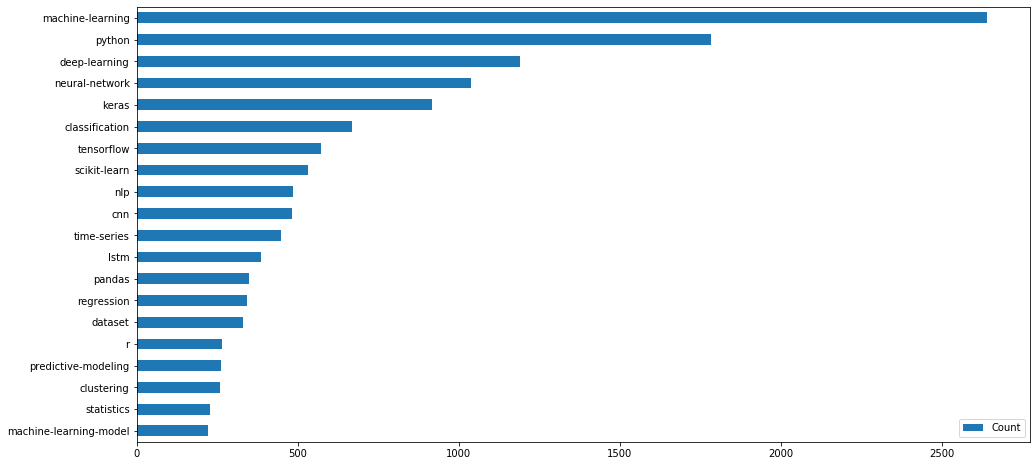

In [11]:
most_used.plot.barh(figsize=(16,8))

How many times a questions with that tag was viewed (AnswerCount).

Will use `enumerate()` function.

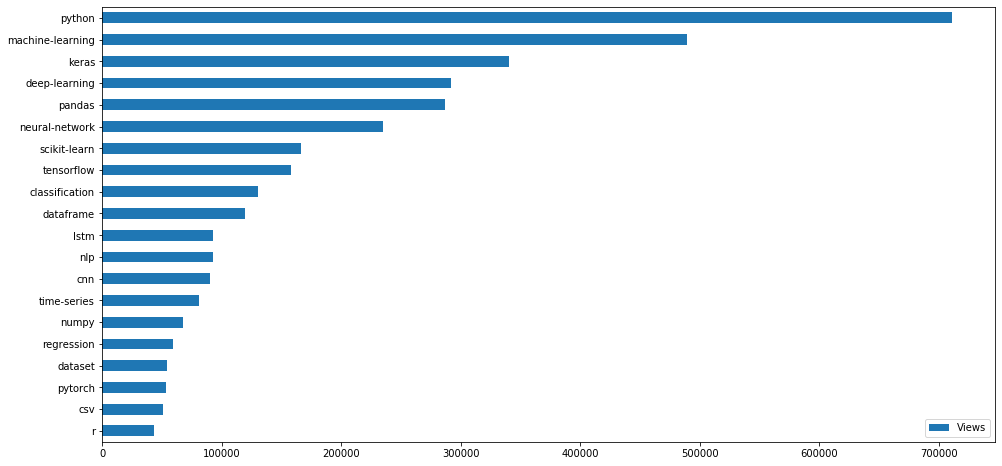

In [12]:
tag_view_count = {}

# Turn each list of tags in each row into an index. 
# e.g. the first list of tags will all be 0. Assign the associated index of ViewCount with that.

for idx, tags in enumerate(questions['Tags']):
    for tag in tags:
        if tag in tag_view_count:
            tag_view_count[tag] += questions['ViewCount'].iloc[idx]
        else:
            tag_view_count[tag] = 1


tag_view_count = pd.DataFrame.from_dict(tag_view_count, orient='index')

tag_view_count.rename(columns={0: "Views"}, inplace=True)

most_viewed = tag_view_count.sort_values(by='Views').tail(20)

most_viewed.plot.barh(figsize=(16,8))

View side by side

array([<matplotlib.axes._subplots.AxesSubplot object at 0x1a1c5b2050>],
      dtype=object)

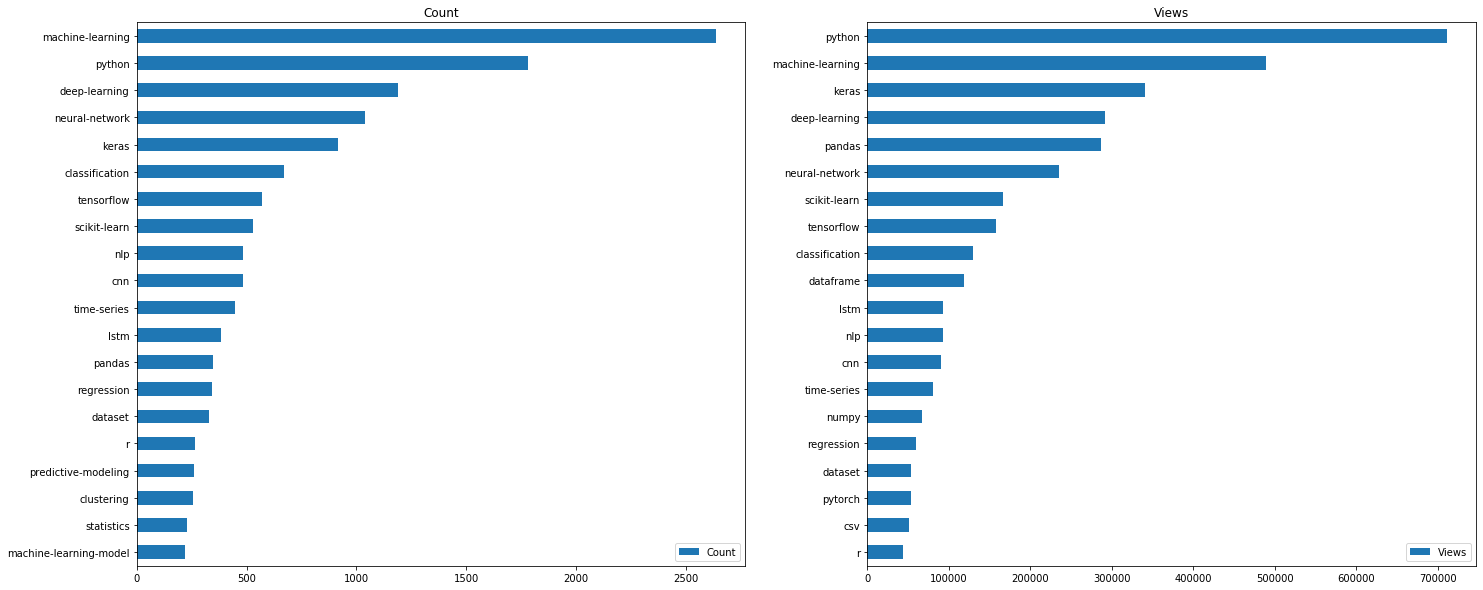

In [13]:
fig, axes = plt.subplots(nrows=1, ncols=2)
fig.set_size_inches((24,10))
most_used.plot(kind='barh', ax=axes[0], subplots=True)
most_viewed.plot(kind='barh', ax=axes[1], subplots=True)

## Relations Between Tags

Most top tags are present in both dataframes. 

Let's see what tags are in `most_used`, but not in `most_viewed`. We can identify them by the missing values in `ViewCount` below.

In [14]:
in_used = pd.merge(most_used, most_viewed, how='left', left_index=True, right_index=True)
in_used

,Count,Views
machine-learning-model,220,NaN
statistics,228,NaN
clustering,257,NaN
predictive-modeling,262,NaN
r,264,43428.0
dataset,330,54362.0
regression,343,59751.0
pandas,349,287014.0
lstm,385,93187.0
time-series,448,81387.0


In [15]:
in_viewed = pd.merge(most_used, most_viewed, how="right", left_index=True, right_index=True)
in_viewed

,Count,Views
r,264.0,43428
csv,NaN,51266
pytorch,NaN,53730
dataset,330.0,54362
regression,343.0,59751
numpy,NaN,67505
time-series,448.0,81387
cnn,483.0,90712
nlp,484.0,92685
lstm,385.0,93187


The tags present in `most_used` and not present in `most_viewed` are:

* `machine-learning-model`
* `statistics`
* `predictive-modeling`
* `r`

And the tags present in most_viewed but not in most_used are:

* `csv`
* `pytorch`
* `dataframe`

Some tags also stand out as being related. For example, `python` is related to `pandas`, as we can find both pythons and pandas in the same country — or better yet, because pandas is a Python library. So by writing about pandas, we can actually simultaneously tackle two tags.

Other pairs of tags, shouldn't be related at all, like `pandas` and `r`:

In [16]:
questions[questions["Tags"].apply(
    lambda tags: True if "r" in tags and "pandas" in tags else False)
]

,Id,CreationDate,Score,ViewCount,Tags,AnswerCount,FavoriteCount
1987,60074,2019-09-11 20:35:17,0,32,"[r, pandas, dplyr]",0,0
5014,49148,2019-04-11 19:41:39,1,86,"[r, data-mining, pandas, matlab, databases]",3,0


One way of trying to gauge how pairs of tags are related to each other, is to count how many times each pair appears together. 

Begin by creating a list of all tags.

In [17]:
all_tags = list(tag_count.index)

We'll now create a dataframe where each row will represent a tag, and each column as well. Something like this:


tag1	tag2	tag3
tag1			
tag2			
tag3			


In [18]:
associations = pd.DataFrame(index=all_tags, columns=all_tags)
associations.iloc[0:4, 0:4]

,multiclass-classification,performance,confusion-matrix,metric
multiclass-classification,NaN,NaN,NaN,NaN
performance,NaN,NaN,NaN,NaN
confusion-matrix,NaN,NaN,NaN,NaN
metric,NaN,NaN,NaN,NaN


Now fill dataframe with zeroes and then, for each lists of tags in `questions['Tags']`, will increment the intervening tags by one. 

The end result will be a df for each pair of tags, it tells us how many times they were used together. 

In [19]:
questions['Tags'][0]

['multiclass-classification',
 'performance',
 'confusion-matrix',
 'metric',
 'scoring']

In [20]:
associations.fillna(0, inplace=True)

for tags in questions["Tags"]:
    associations.loc[tags, tags] += 1

Will focus our attention on the most used tags as the dataframe is quite large. We'll add some colors to make it easier to talk about the dataframe.

In [21]:
relations_most_used = associations.loc[most_used.index, most_used.index]

def style_cells(x):
    helper_df = pd.DataFrame('', index=x.index, columns=x.columns)
    helper_df.loc["time-series", "r"] = "background-color: yellow"
    helper_df.loc["r", "time-series"] = "background-color: yellow"
    for k in range(helper_df.shape[0]):
        helper_df.iloc[k,k] = "color: blue"
    
    return helper_df

relations_most_used.style.apply(style_cells, axis=None)

,machine-learning-model,statistics,clustering,predictive-modeling,r,dataset,regression,pandas,lstm,time-series,cnn,nlp,scikit-learn,tensorflow,classification,keras,neural-network,deep-learning,python,machine-learning
machine-learning-model,220,3,3,21,7,12,8,4,5,6,4,4,18,9,21,16,10,18,37,138
statistics,3,228,3,15,16,16,15,3,1,20,1,3,6,0,17,3,11,12,35,89
clustering,3,3,257,0,16,5,2,5,3,20,0,9,24,0,12,0,8,2,45,61
predictive-modeling,21,15,0,262,13,7,28,4,12,28,6,1,12,6,26,11,13,32,35,122
r,7,16,16,13,264,6,10,2,3,22,2,3,1,1,10,10,9,5,24,63
dataset,12,16,5,7,6,330,6,12,6,6,10,11,9,9,27,12,20,31,53,99
regression,8,15,2,28,10,6,343,6,11,24,6,2,37,9,33,31,42,21,59,117
pandas,4,3,5,4,2,12,6,349,7,18,1,3,37,3,3,3,1,1,241,62
lstm,5,1,3,12,3,6,11,7,385,83,24,19,2,38,18,128,66,100,59,66
time-series,6,20,20,28,22,6,24,18,83,448,8,0,12,9,24,49,33,41,102,126


The cells highlighted in yellow tell us that time-series was used together with r 22 times. The values in blue tell us how many times each of the tags was used. We saw earlier that machine-learning was used 2693 times and we confirm it in this dataframe.

It's hard for a human to understand what is going on in this dataframe. Let's create a heatmap. But before we do it, let's get rid of the values in blue, otherwise the colors will be too skewed.

In [22]:
for i in range(relations_most_used.shape[0]):
    relations_most_used.iloc[i,i] = pd.np.NaN

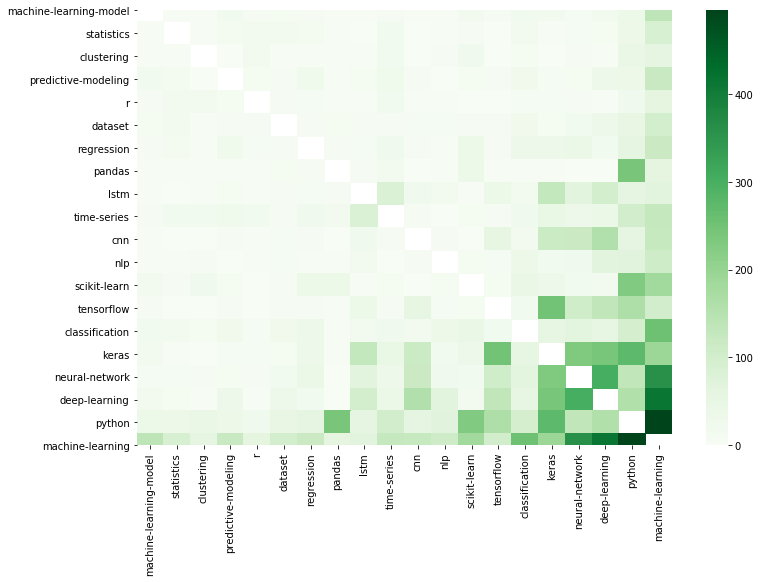

In [23]:
plt.figure(figsize=(12,8))
sns.heatmap(relations_most_used, cmap="Greens", annot=False)

The most used tags also seem to have the strongest relationships, as given by the dark concentration in the bottom right corner. However, this could simply be because each of these tags is used a lot, and so end up being used together a lot without possibly even having any strong relation between them.

A more intuitive manifestation of this phenomenon is the following. A lot of people buy bread, a lot of people buy toilet paper, so they end up being purchased together a lot, but purchasing one of them doesn't increase the chances of purchasing the other.

Another shortcoming of this attempt is that it only looks at relations between pairs of tags and not between multiple groups of tags. For example, it could be the case that when used together, dataset and scikit-learn have a "strong" relation to pandas, but each by itself doesn't.

So how do we attack both these problems? There is a powerful data mining technique that allows us to handle this: association rules. Association rules allow us to analytically spot relations like "people who purchase milk, also purchase eggs". Moreover, we can also measure how strong this relations are on several fronts: how common the relation is, how strong it is, and how independent the components of the relationship are (toilet paper and bread are probably more independent than eggs and milk — you'll learn more about statistical independence) in the next step).

We won't get into the details of it, as the technique is out of scope for this course, but it is a path worth investigating!

## Enter Domain Knowledge

Keras, scikit-learn, TensorFlow are all Python libraries that allow their users to employ deep learning (a type of neural network).

Most of the top tags are all intimately related with one central machine learning theme: deep learning. If we want to be very specific, we can suggest the creation of Python content that uses deep learning for classification problems (and other variations of this suggestion).

At the glance of an eye, someone with sufficient domain knowledge can tell that the most popular topic at the moment, as shown by our analysis, is deep learning.

## Just a fad?

"Is deep learning just a fad?" Ideally, the content we decide to create will be the most useful for as long as possible. Could interest in deep learning be slowing down? 

In this we will track the interest in deep learning across time. We will:

* Count how many deep learning questions are asked per time period.
* The total amount of questions per time period.
* How many deep learning questions there are relative to the total amount of questions per time period.

In [24]:
all_q = pd.read_csv('dataset/all_questions.csv', parse_dates=["CreationDate"])

all_q.head()

,Id,CreationDate,Tags
0,45416,2019-02-12 00:36:29,<python><keras><tensorflow><cnn><probability>
1,45418,2019-02-12 00:50:39,<neural-network>
2,45422,2019-02-12 04:40:51,<python><ibm-watson><chatbot>
3,45426,2019-02-12 04:51:49,<keras>
4,45427,2019-02-12 05:08:24,<r><predictive-modeling><machine-learning-mode...


In [25]:
all_q.tail()

,Id,CreationDate,Tags
21571,36971,2018-08-15 14:19:01,<statistics><data>
21572,36974,2018-08-15 14:40:27,<machine-learning><neural-network><classifier>
21573,36975,2018-08-15 14:53:43,<machine-learning><classification>
21574,36979,2018-08-14 19:31:43,<tensorflow><python>
21575,36985,2018-08-15 17:01:29,<python><deep-learning><tensorflow>


In [26]:
# Cleaning the Tags column

all_q["Tags"] = all_q["Tags"].str.replace("^<|>$", "").str.split("><")

Before deciding which questions should be classified as being deep learning questions, we should decide what tags are deep learning tags.

The definition of what constitutes a deep learning tag we'll use is: a tag that belongs to the list `["lstm", "cnn", "scikit-learn", "tensorflow", "keras", "neural-network", "deep-learning"]`.

This list was obtained by looking at all the tags in most_used and seeing which ones had any relation to deep learning. You can use Google and read the tags descriptions to reach similar results.

We'll now create a function that assigns 1 to deep learning questions and 0 otherwise; and we use it.

In [35]:
# Deep learning should contain:
deep_learning_topics = ['deep_learning', 'machine-learning', 'neural-network', 'keras', 'tensorflow', 'scikit-learn']

def class_deep_learning(tags):
    for tag in tags:
        if tag in deep_learning_topics:
            return 1
        return 0

all_q['DeepLearning'] = all_q['Tags'].apply(class_deep_learning)
all_q.sample(5)

,Id,CreationDate,Tags,Year_Month,DeepLearning
13618,62225,2019-10-25 16:09:12,"[python, deep-learning, nlp, image-preprocessi...",2019-10,0
7125,27645,2018-02-09 10:28:03,"[deep-learning, feature-extraction, pca, autoe...",2018-02,0
12887,30474,2018-04-18 11:54:37,"[keras, lstm]",2018-04,1
6875,6068,2015-06-10 13:16:17,"[machine-learning, deep-learning, research]",2015-06,1
16396,45156,2019-02-06 10:58:20,"[python, data-mining, text-mining, data-cleaning]",2019-02,0


The data-science-techonology landscape isn't something as dynamic to merit daily, weekly, or even monthly tracking. So will track quarterly.

Since we don't have all the data for the first quarter of 2020, we'll get rid of those dates:

In [36]:
all_q = all_q[all_q['CreationDate'].dt.year < 2020]

Creating a column that identifies the quarter which a question was asked

In [37]:
def fetch_quarter(datetime):
    year = str(datetime.year)[-2:]
    quarter = str(((datetime.month-1) // 3) + 1)
    return "{y}Q{q}".format(y=year, q=quarter)

all_q["Quarter"] = all_q["CreationDate"].apply(fetch_quarter)

all_q.head()

,Id,CreationDate,Tags,Year_Month,DeepLearning,Quarter
0,45416,2019-02-12 00:36:29,"[python, keras, tensorflow, cnn, probability]",2019-02,0,19Q1
1,45418,2019-02-12 00:50:39,[neural-network],2019-02,1,19Q1
2,45422,2019-02-12 04:40:51,"[python, ibm-watson, chatbot]",2019-02,0,19Q1
3,45426,2019-02-12 04:51:49,[keras],2019-02,1,19Q1
4,45427,2019-02-12 05:08:24,"[r, predictive-modeling, machine-learning-mode...",2019-02,0,19Q1


Group by quarter and:
* Count the number of deep learning questions.
* Count the total number of questions.
* Compute the ratio between the two numbers above.

In [38]:
quarterly = all_q.groupby('Quarter').agg({"DeepLearning": ['sum', 'size']})

quarterly.columns = ['DeepLearningQuestions', 'TotalQuestions']

quarterly['DeepLearningRate'] = quarterly['DeepLearningQuestions']/quarterly['TotalQuestions']

# The following is done to help with visualisations later.
quarterly.reset_index(inplace=True)
quarterly.sample(5)

,Quarter,DeepLearningQuestions,TotalQuestions,DeepLearningRate
21,19Q3,1046,2394,0.436926
7,16Q1,193,516,0.374031
1,14Q3,65,189,0.343915
6,15Q4,141,382,0.369110
18,18Q4,604,1294,0.466770


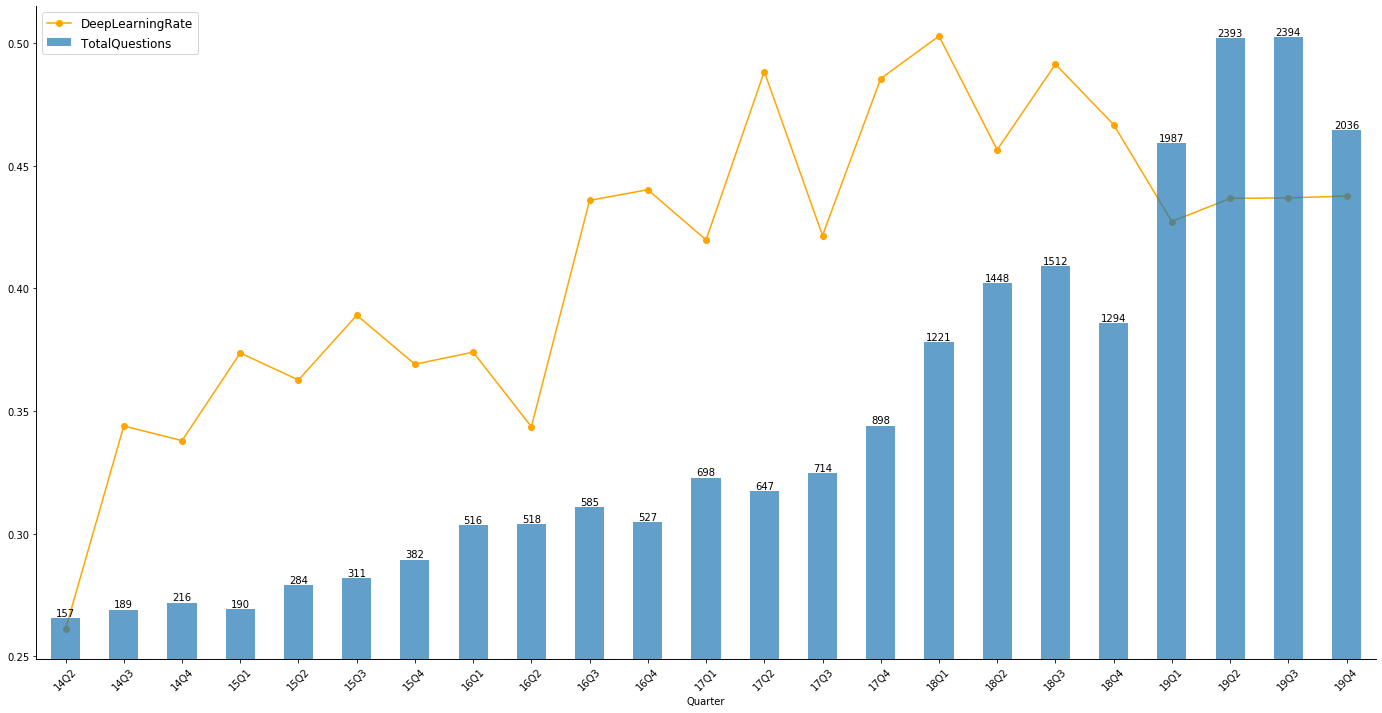

In [50]:
ax1 = quarterly.plot(x='Quarter', y='DeepLearningRate', 
                     kind='line', linestyle='-', marker='o', color='orange',
                    figsize=(24,12)
                    )

ax2 = quarterly.plot(x="Quarter", y="TotalQuestions",
                    kind='bar', ax=ax1, secondary_y=True, alpha=0.7, rot=45)

for idx, t in enumerate(quarterly['TotalQuestions']):
    ax2.text(idx, t, str(t), ha='center', va='bottom')
xlims = ax1.get_xlim()
    
ax1.get_legend().remove()

handles1, labels1 = ax1.get_legend_handles_labels()
handles2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(handles=handles1 + handles2,
           labels=labels1 + labels2,
           loc='upper left', prop={'size':12})

for ax in (ax1, ax2):
    for where in ("top", "right"):
        ax.spines[where].set_visible(False)
        ax.tick_params(right=False, labelright=False)

It seems that deep learning questions was a high-growth trend since the start of DSSE and it looks like it declined a little and now plateauing. There is no evidence to suggest that interest in deep learning is decreasing and so we maintain our previous idea of proposing that we create deep learning content.